In [207]:
import pyreadr as py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

> ### Data downloading
Data link  
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6C3JR1

##### Columns description
* **faultNumber** ranges from 1 to 20 in the “Faulty” datasets and represents the fault type in the TEP. The “FaultFree” datasets only contain fault 0 (i.e. normal operating conditions).
* **simulationRun** ranges from 1 to 500 and represents a different random number generator state from which a full TEP dataset was generated (Note: the actual seeds used to generate training and testing datasets were non-overlapping).
* **sample** ranges either from 1 to 500 (“Training” datasets) or 1 to 960 (“Testing” datasets). The TEP variables (columns 4 to 55) were sampled every 3 minutes for a total duration of 25 hours and 48 hours respectively. Note that the faults were introduced 1 and 8 hours into the Faulty Training and Faulty Testing datasets, respectively.
* **columns 4-55** contain the process variables; the column names retain the original variable names.

In [215]:
! unzip dataverse_files.zip -d dataverse_files

Archive:  dataverse_files.zip
  inflating: dataverse_files/TEP_FaultFree_Testing.RData  
  inflating: dataverse_files/TEP_FaultFree_Training.RData  
  inflating: dataverse_files/TEP_Faulty_Testing.RData  
  inflating: dataverse_files/TEP_Faulty_Training.RData  
  inflating: dataverse_files/MANIFEST.TXT  


In [216]:
#reading train data in .R format
a1 = py.read_r("dataverse_files/TEP_FaultFree_Training.RData")
a2 = py.read_r("dataverse_files/TEP_Faulty_Training.RData")

In [217]:
#reading test data in .R format
a3 = py.read_r("dataverse_files/TEP_FaultFree_Testing.RData")
a4 = py.read_r("dataverse_files/TEP_Faulty_Testing.RData")

In [210]:
print("Objects that are present in a1 :", a1.keys())
print("Objects that are present in a2 :", a2.keys())
print("Objects that are present in a3 :", a3.keys())
print("Objects that are present in a4 :", a4.keys())

Objects that are present in a1 : odict_keys(['fault_free_training'])
Objects that are present in a2 : odict_keys(['faulty_training'])
Objects that are present in a3 : odict_keys(['fault_free_testing'])
Objects that are present in a4 : odict_keys(['faulty_testing'])


In [211]:
# concatinating the train and the test dataset
# train dataframe
raw_train = pd.concat([a1['fault_free_training'], a2['faulty_training']])
# test dataframe
raw_test = pd.concat([a3['fault_free_testing'], a4['faulty_testing']])

In [212]:
raw_train.groupby(['faultNumber','simulationRun']).size()

faultNumber  simulationRun
0.0          1.0              500
             2.0              500
             3.0              500
             4.0              500
             5.0              500
                             ... 
20.0         496.0            500
             497.0            500
             498.0            500
             499.0            500
             500.0            500
Length: 10500, dtype: int64

In [213]:
raw_test.groupby(['faultNumber','simulationRun']).size()

faultNumber  simulationRun
0            1.0              960
             2.0              960
             3.0              960
             4.0              960
             5.0              960
                             ... 
20           496.0            960
             497.0            960
             498.0            960
             499.0            960
             500.0            960
Length: 10500, dtype: int64

> ### EDA

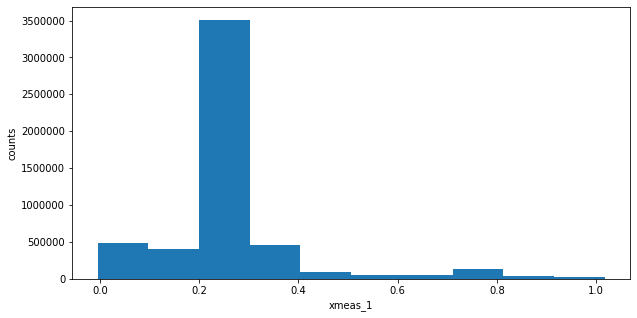

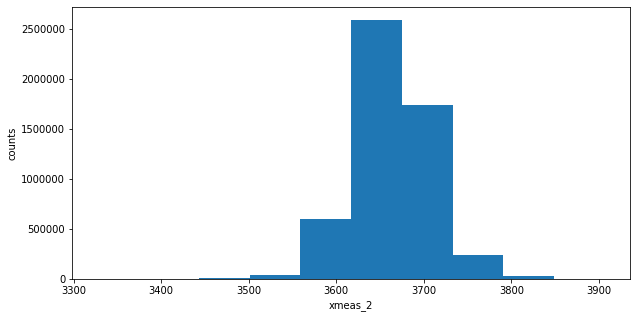

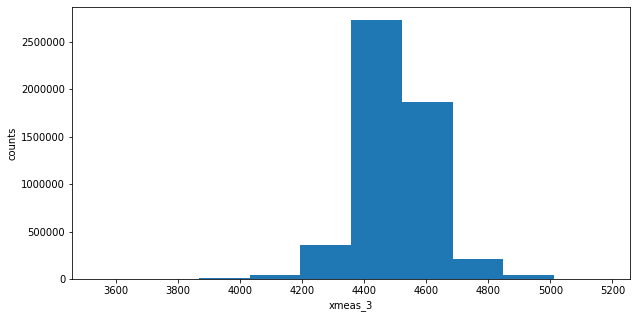

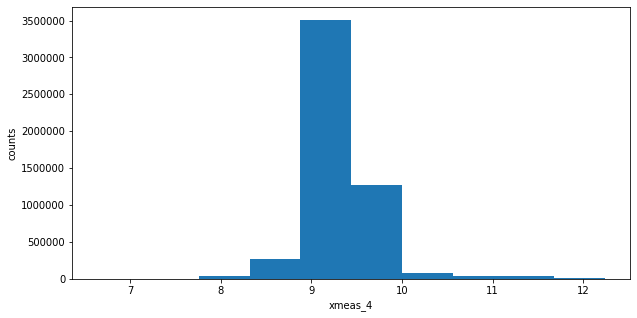

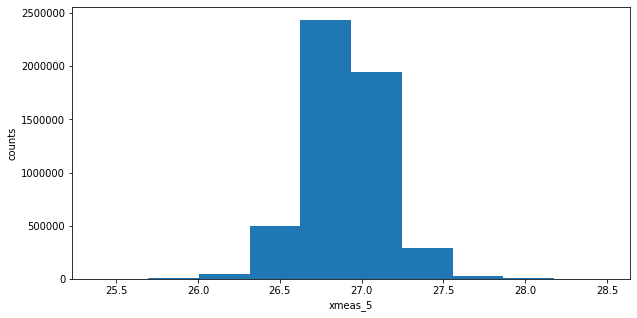

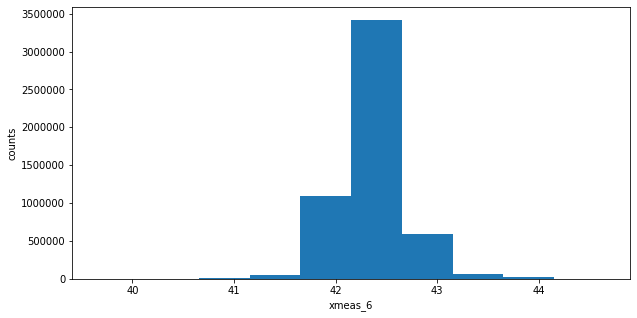

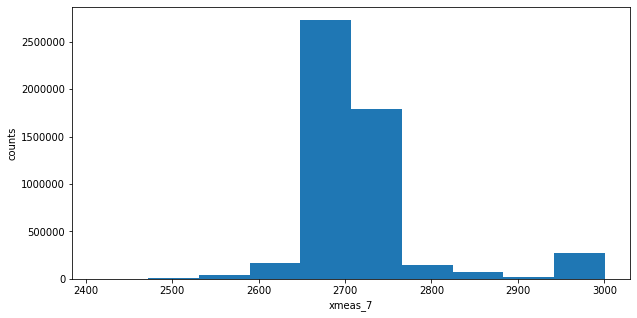

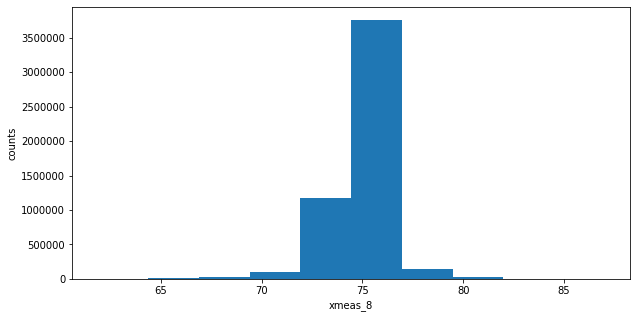

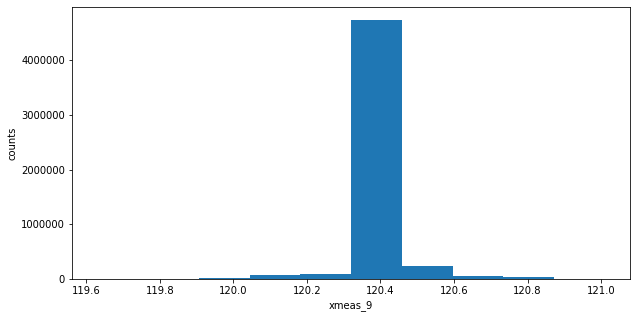

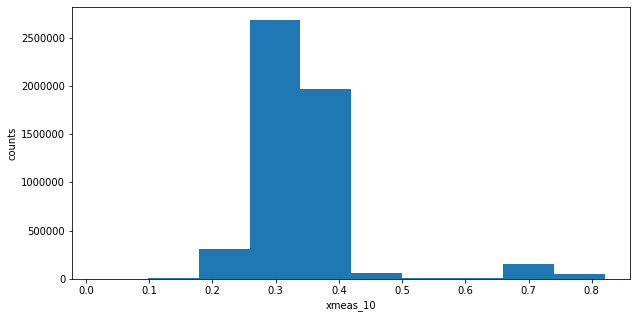

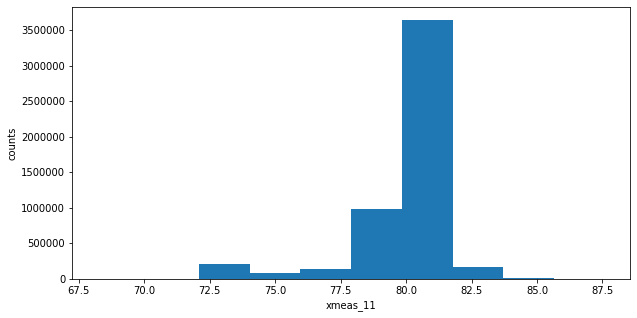

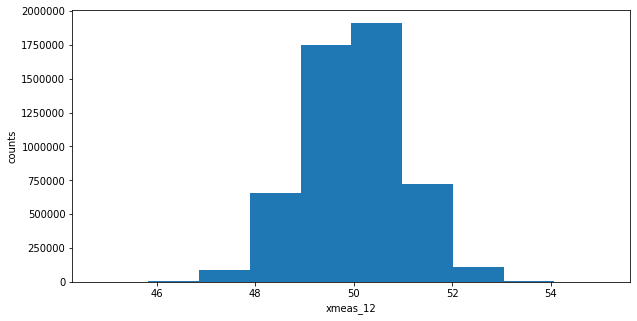

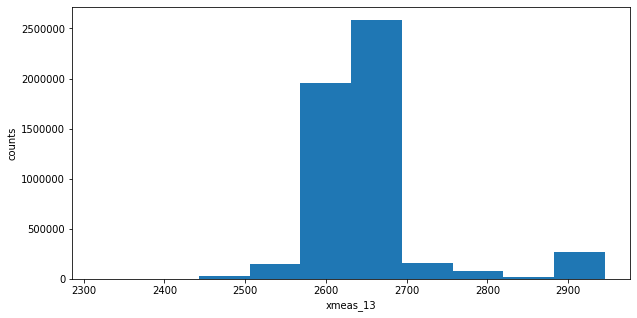

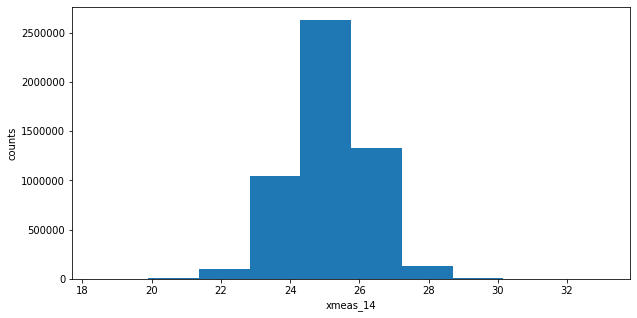

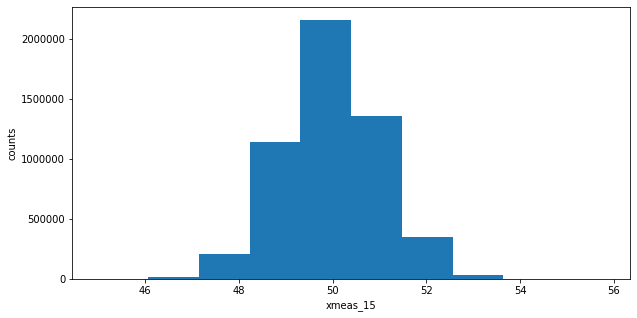

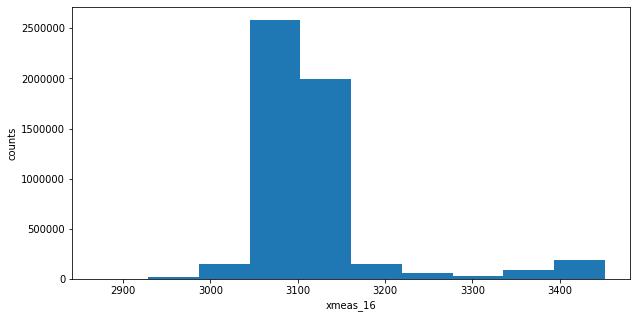

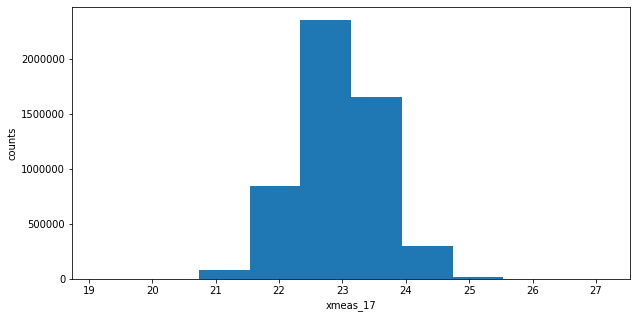

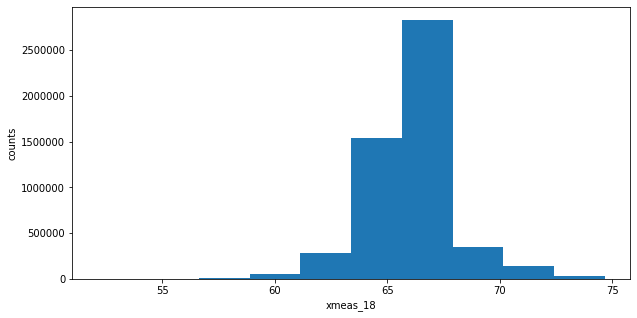

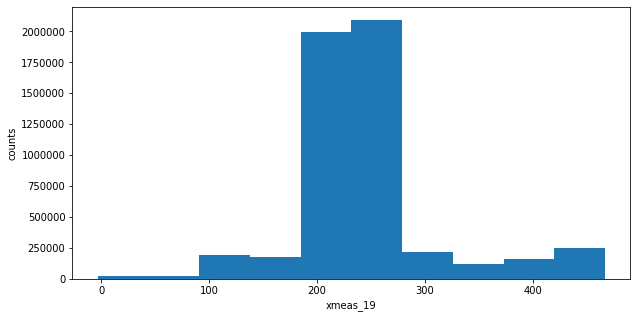

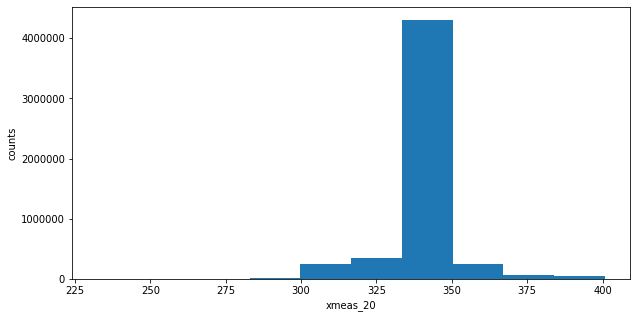

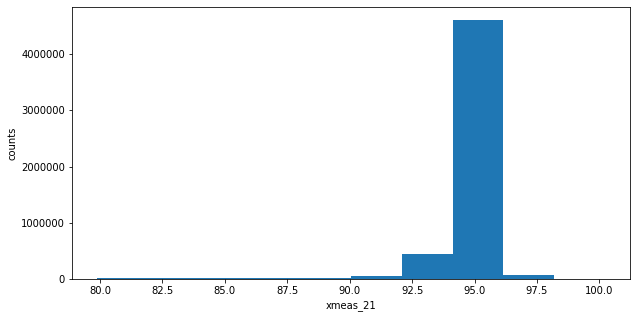

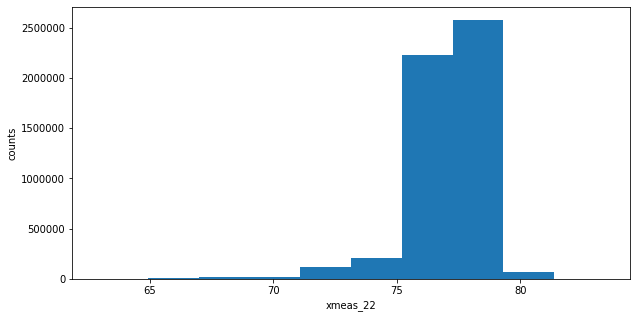

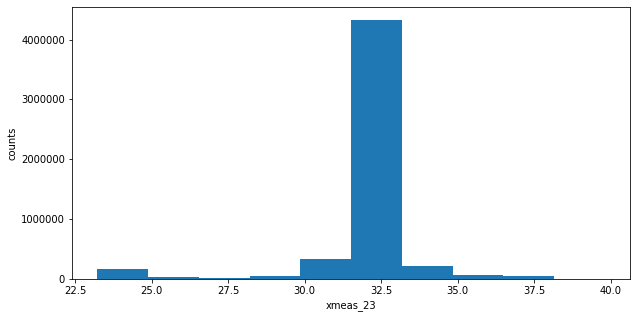

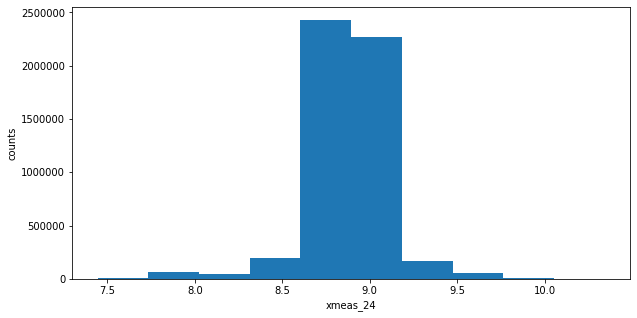

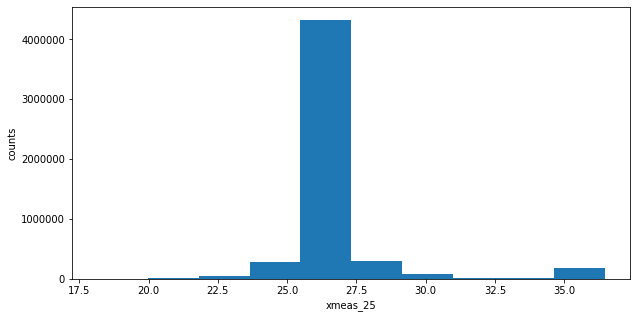

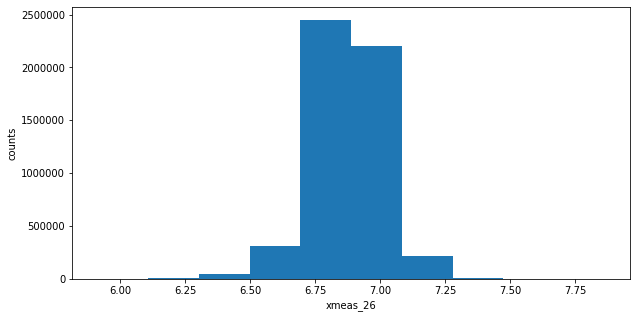

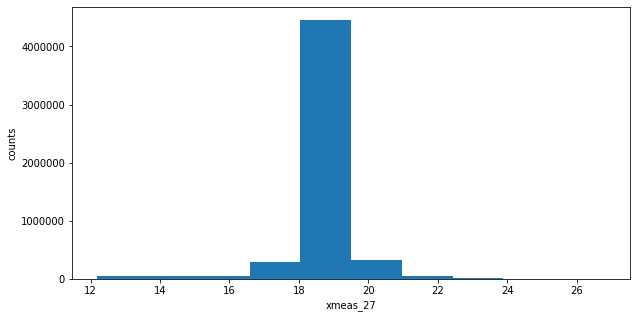

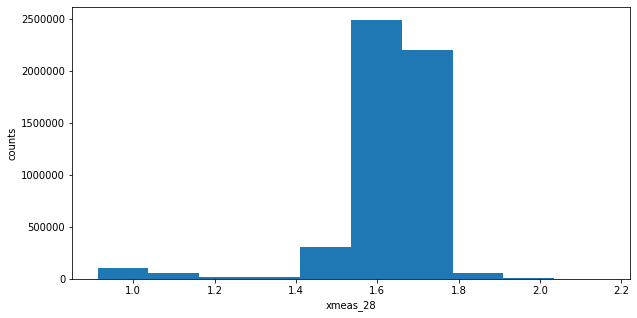

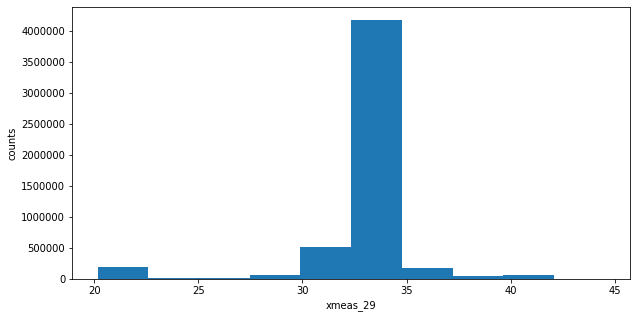

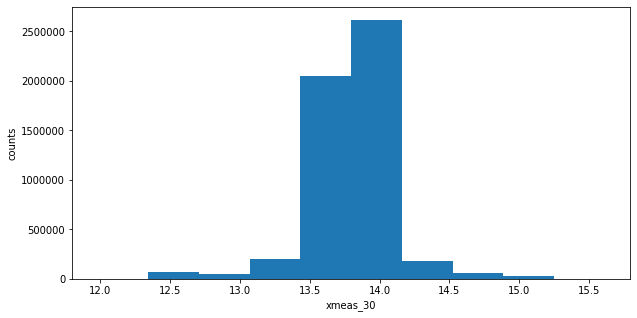

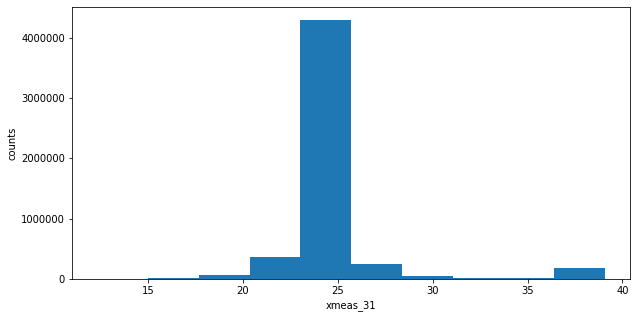

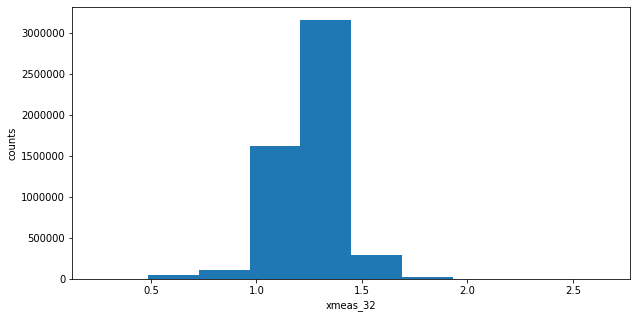

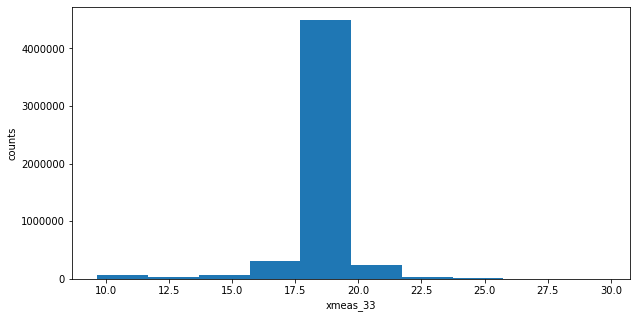

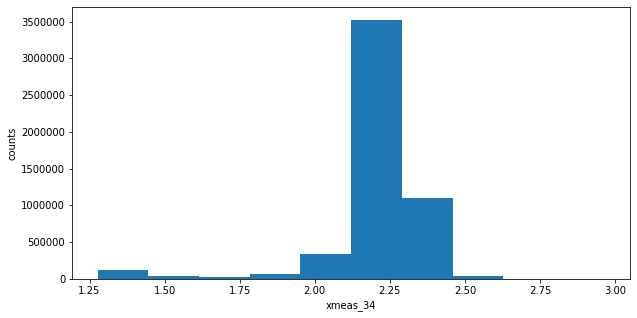

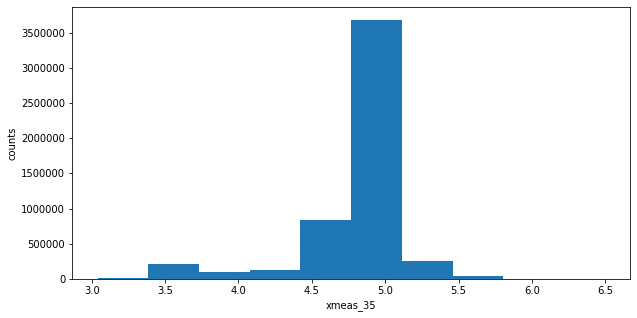

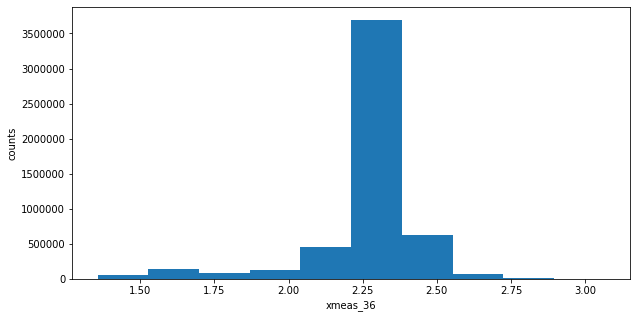

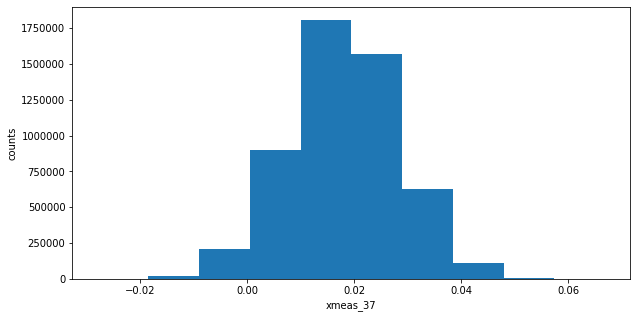

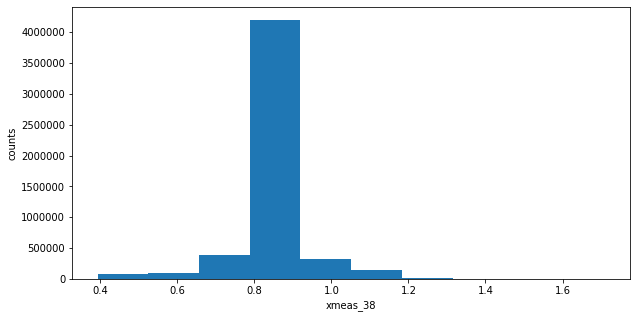

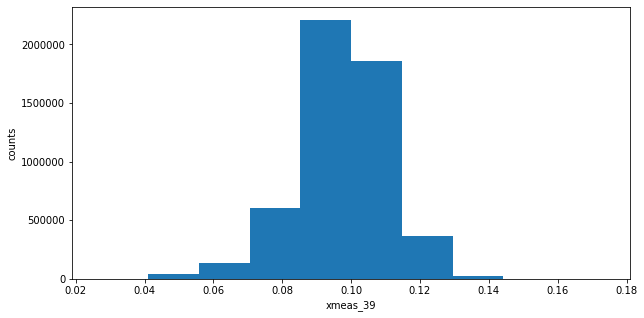

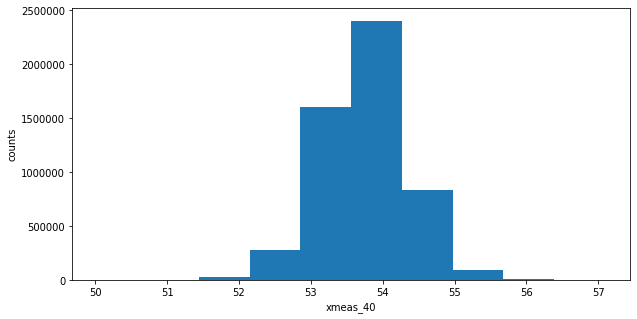

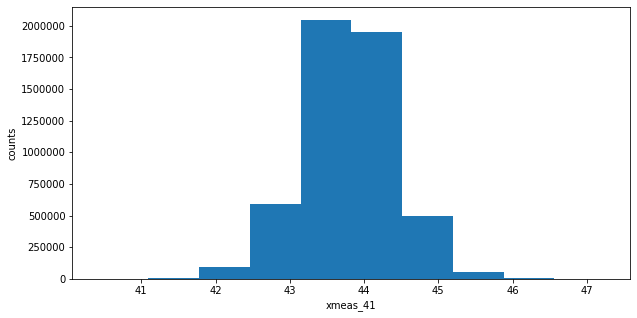

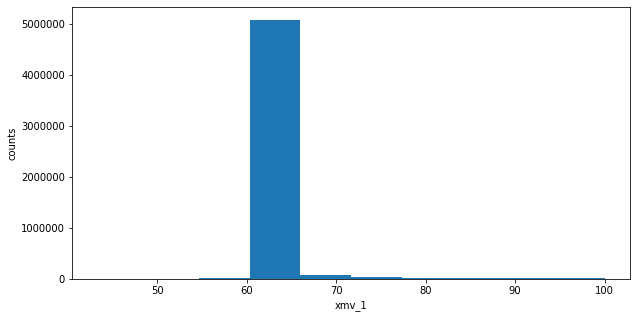

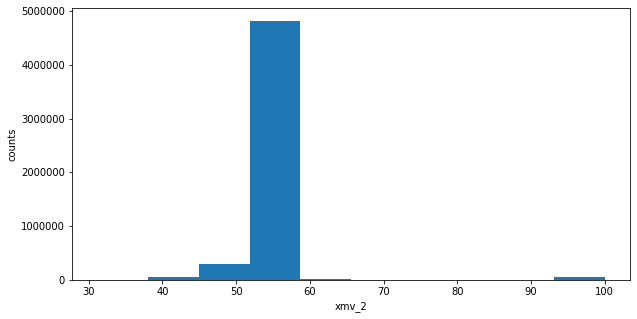

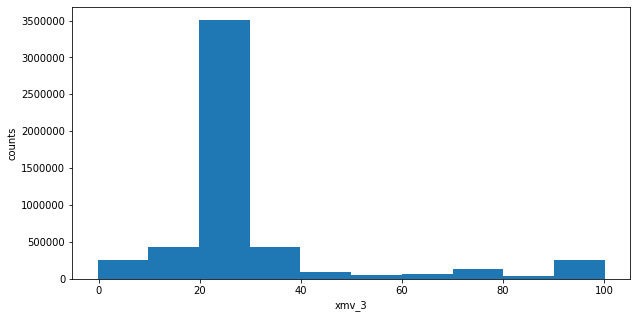

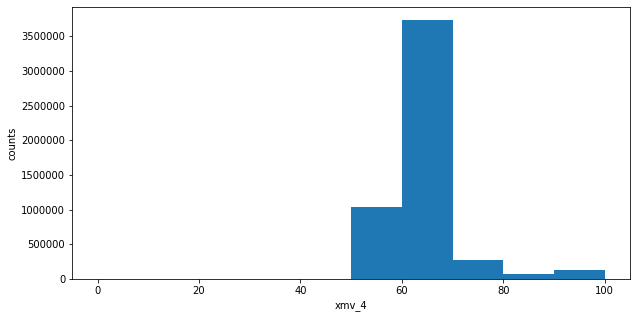

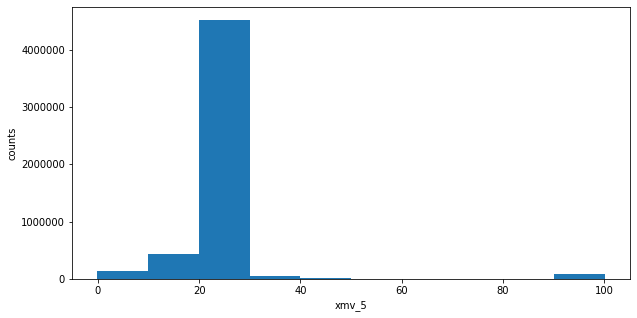

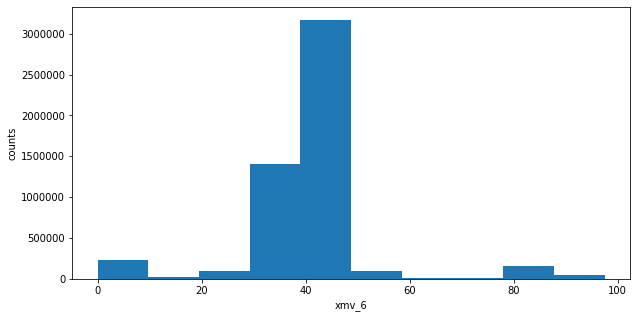

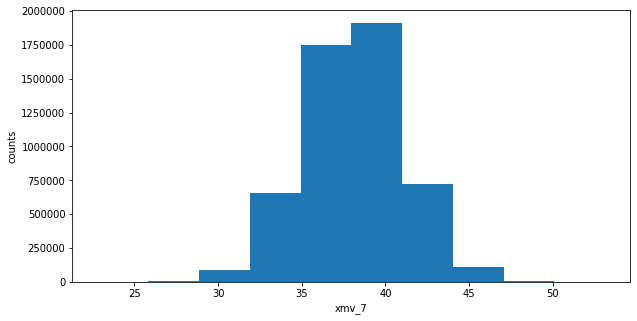

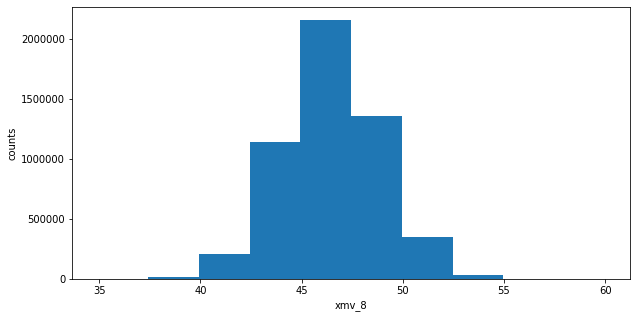

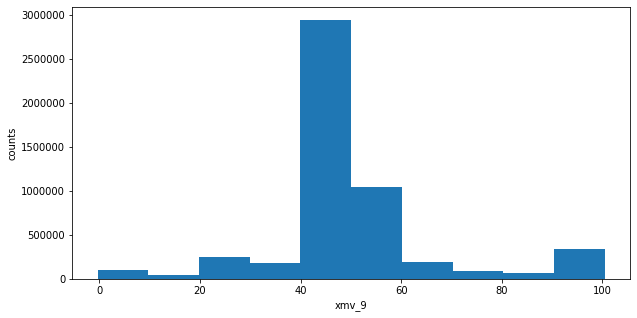

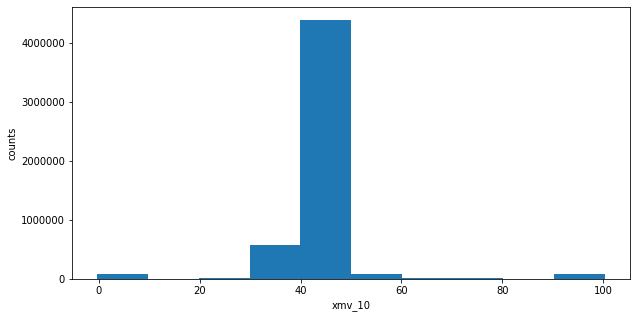

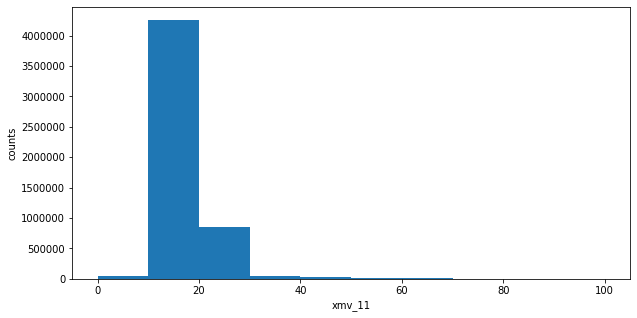

In [194]:
#Program to plot the histogram of the features in the train dataset
for col in raw_train.columns[3:]:
    plt.figure(figsize=(10,5))
    #plt.subplot(26,2,i)
    plt.hist(raw_train[col])
    plt.xlabel(col)
    plt.ylabel('counts')
    plt.show()

> ### Sampling

Described in "Data Preparation for Deep Learning Models" in [that article](https://medium.com/@mrunal68/tennessee-eastman-process-simulation-data-for-anomaly-detection-evaluation-d719dc133a7f)

In [195]:
%%time
# Program to construct the sample train data
frame = []

for i in set(raw_train['faultNumber']): 
    b_i = pd.DataFrame()
    if i == 0:
        b_i = raw_train[raw_train['faultNumber'] == i][0:20000]
        frame.append(b_i)
    else:
        fr = []
        b = raw_train[raw_train['faultNumber'] == i]
        for x in range(1,25):
            b_x = b[b['simulationRun'] == x][20:500]
            fr.append(b_x)
        
        b_i = pd.concat(fr)
    frame.append(b_i)      
    
sampled_train = pd.concat(frame)

CPU times: user 2.28 s, sys: 965 ms, total: 3.25 s
Wall time: 3.35 s


In [196]:
%%time
# Program to construct the sample CV Data
frame = []

for i in set(raw_train['faultNumber']):
    b_i = pd.DataFrame()
    if i == 0:
        b_i = raw_train[raw_train['faultNumber'] == i][20000:30000]
        frame.append(b_i)
    else:
        fr = []
        b = raw_train[raw_train['faultNumber'] == i]
        for x in range(26,35):
            b_x = b[b['simulationRun'] == x][20:500]
            fr.append(b_x)
        
        b_i = pd.concat(fr)  
    frame.append(b_i)
    
sampled_cv = pd.concat(frame)

CPU times: user 1.77 s, sys: 746 ms, total: 2.52 s
Wall time: 2.53 s


In [197]:
%%time
# Program to construct Sampled raw_test data
frame = []
for i in set(raw_test['faultNumber']):
    b_i = pd.DataFrame()
    if i == 0:
        b_i = raw_test[raw_test['faultNumber'] == i][0:2000]
        frame.append(b_i)
    else:
        fr = []
        b = raw_test[raw_test['faultNumber'] == i]
        for x in range(1,11):
            b_x = b[b['simulationRun'] == x][160:660]
            fr.append(b_x)
        b_i = pd.concat(fr)
    frame.append(b_i)      
    
sampled_test = pd.concat(frame)

CPU times: user 3.18 s, sys: 3.16 s, total: 6.35 s
Wall time: 6.63 s


In [198]:
len(sampled_train), len(sampled_cv), len(sampled_test)

(270400, 106400, 104000)

In [199]:
sampled_data_path = "sampled_data/"

sampled_train.to_csv(sampled_data_path + "train.csv")
sampled_test.to_csv(sampled_data_path + "test.csv")
sampled_cv.to_csv(sampled_data_path + "cv.csv")

> ### Preparing data

In [200]:
#Sorting the Datasets wrt to the simulation runs
sampled_train.sort_values(['simulationRun', 'faultNumber'], inplace=True)
sampled_test.sort_values(['simulationRun', 'faultNumber'], inplace=True)
sampled_cv.sort_values(['simulationRun', 'faultNumber'], inplace=True)

In [201]:
# Removing faults 3,9 and 15 
tr = sampled_train.drop(
                        sampled_train[(sampled_train['faultNumber'] == 3) |\
                                      (sampled_train['faultNumber'] == 9) |\
                                      (sampled_train['faultNumber'] == 15)].index)

In [202]:
# Removing faults 3,9 and 15 
ts = sampled_test.drop(
                       sampled_test[(sampled_test['faultNumber'] == 3) |\
                                    (sampled_test['faultNumber'] == 9) |\
                                    (sampled_test['faultNumber'] == 15)].index)

In [203]:
# Removing faults 3,9 and 15 
cv = sampled_cv.drop(
                      sampled_cv[(sampled_cv['faultNumber'] == 3) |\
                                 (sampled_cv['faultNumber'] == 9) |\
                                 (sampled_cv['faultNumber'] == 15)].index)

In [204]:
#converting the class labels to categorical values and removing unnecessary features from train, test and cv data.
y_train = to_categorical(train['faultNumber'], num_classes=21)
y_test = to_categorical(ts['faultNumber'], num_classes=21)
y_cv = to_categorical(cv['faultNumber'], num_classes=21)

tr = tr.drop(['faultNumber', 'simulationRun', 'sample'], axis=1)
ts = ts.drop(['faultNumber', 'simulationRun', 'sample'], axis=1)
cv = cv.drop(['faultNumber', 'simulationRun', 'sample'], axis=1)

In [205]:
# REsizing the train, test and cv data.
x_train = np.array(tr)[:, :, np.newaxis]
x_test = np.array(ts)[:, :, np.newaxis]
x_cv = np.array(cv)[:, :, np.newaxis]

> ### Modeling: LSTM-1

In [206]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

#### Models configuration

In [169]:
model_1 = Sequential()
model_1.add(LSTM(256, input_shape=(52, 1), return_sequences=True))
model_1.add(LSTM(128, return_sequences=False))
model_1.add(Dense(300))
model_1.add(Dropout(0.5))
model_1.add(Dense(128))
model_1.add(Dense(21, activation='softmax'))
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 52, 256)           264192    
_________________________________________________________________
lstm_19 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_28 (Dense)             (None, 300)               38700     
_________________________________________________________________
dropout_10 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 128)               38528     
_________________________________________________________________
dense_30 (Dense)             (None, 21)                2709      
Total params: 541,249
Trainable params: 541,249
Non-trainable params: 0
_________________________________________________________________
None

#### Training

In [170]:
n_epochs = 2
# n_epochs = 50

history_1 = model_1.fit(x_train, y_train, validation_data=(x_cv, y_cv), batch_size=256, epochs=n_epochs, verbose=2)

Train on 230080 samples, validate on 93440 samples
Epoch 1/2
 - 816s - loss: 1.7047 - acc: 0.4603 - val_loss: 1.2599 - val_acc: 0.6171
Epoch 2/2
 - 771s - loss: 1.2163 - acc: 0.6000 - val_loss: 1.1521 - val_acc: 0.6463


#### Metrics

In [171]:
history_1.history

{'val_loss': [1.259857696599859, 1.1521447392857433],
 'val_acc': [0.6170804794520548, 0.6463291952054795],
 'loss': [1.7046836895803417, 1.216274688737946],
 'acc': [0.46030076494303135, 0.5999565368733254]}

In [177]:
def plots_and_metrics(h, m):

    epochs_arr = list(range(1, len(h.history['acc']) + 1))
    
    # Plot training & validation accuracy values
    plt.plot(epochs_arr, h.history['acc'])
    plt.plot(epochs_arr, h.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(epochs_arr)
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(epochs_arr, h.history['loss'])
    plt.plot(epochs_arr, h.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(epochs_arr)
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    score, accuracy = m.evaluate(x_test, y_test, verbose=0)
    print('Test accuracy:', accuracy)
    print("Test loss:", score)

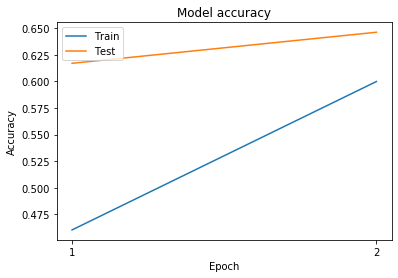

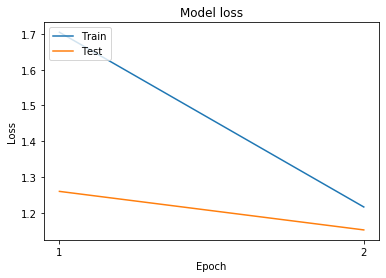

Test accuracy: 0.5756067415730337
Test loss: 1.2440055150088953
CPU times: user 5min 31s, sys: 25.7 s, total: 5min 56s
Wall time: 1min 45s


In [178]:
%%time

plots_and_metrics(history_1, model_1)

In [179]:
y_test_pred_1 = model_1.predict_proba(x_test)

In [180]:
y_test_pred_1.shape

(89000, 21)

In [181]:
np.argmax(y_test_pred_1, axis=1)

array([0, 0, 0, ..., 0, 0, 0])

In [182]:
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

> ### Modeling: LSTM-2

In [183]:
model_2 = Sequential()
model_2.add(LSTM(128, input_shape=(52, 1), return_sequences=False))
model_2.add(Dense(300))
model_2.add(Dropout(0.5))
model_2.add(Dense(128))
model_2.add(Dense(21, activation='softmax'))
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dense_31 (Dense)             (None, 300)               38700     
_________________________________________________________________
dropout_11 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               38528     
_________________________________________________________________
dense_33 (Dense)             (None, 21)                2709      
Total params: 146,497
Trainable params: 146,497
Non-trainable params: 0
_________________________________________________________________
None


#### Training

In [184]:
n_epochs = 3
# n_epochs = 50

history_2 = model_2.fit(x_train, y_train, validation_data = (x_cv, y_cv), batch_size=256, epochs=n_epochs, verbose=2)

Train on 230080 samples, validate on 93440 samples
Epoch 1/3
 - 148s - loss: 1.8718 - acc: 0.4147 - val_loss: 1.4492 - val_acc: 0.5634
Epoch 2/3
 - 147s - loss: 1.3545 - acc: 0.5594 - val_loss: 1.2647 - val_acc: 0.6153
Epoch 3/3
 - 156s - loss: 1.2670 - acc: 0.5861 - val_loss: 1.2183 - val_acc: 0.6241


#### Metrics

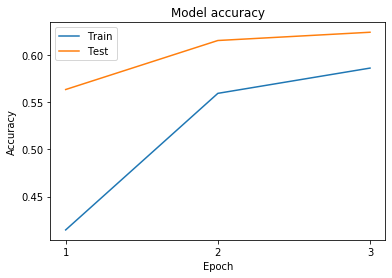

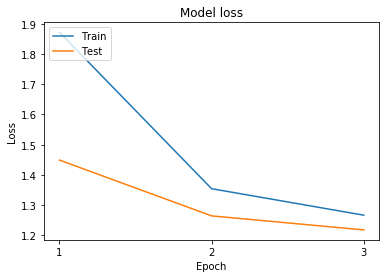

Test accuracy: 0.5585393258426966
Test loss: 1.3055753506076238
CPU times: user 1min 2s, sys: 6.36 s, total: 1min 8s
Wall time: 27.8 s


In [185]:
%%time

plots_and_metrics(history_2, model_2)

> ### Upsampling (???)
Since fault is introduced at one hour of each simulation, let us train the LSTM models with 20 samples at a time. So in model 3 and model 4, each input to the model will have 20 samples of 52 Dim from the train dataset.

In [ ]:
label_train = []
for row in range(9160):
   
    label_train.append(tr['faultNumber'][row * 20])

    
label_test = []
for row in range(4450):
   
    label_test.append(ts['faultNumber'][row * 20])
    
label_cv = []
for row in range(4672):
    label_cv.append(cv['faultNumber'][row * 20])

In [ ]:
#Transforming the train, test and cv data, to get an array of shape (20,52)
tr_ = tr.values
tr_arr = np.empty([9160,20,52])
for x in range(9160):
    tr_arr[x] = tr_[20 * x : 20+20*x]

#ts_ = norm.transform(ts.values)
ts_ = ts.values
ts_arr = np.empty([4450,20,52])

for x in range(4450):
    ts_arr[x] = ts_[20 * x : 20+20*x]

#cv_ar = norm.transform(cv_.values)
cv_ar = cv_.values
cv_arr = np.empty([4672,20,52])
for x in range(4672):
    cv_arr[x] = cv_ar[20 * x : 20+20*x]

In [ ]:
y_train = to_categorical(label_train,num_classes=21)
y_test = to_categorical(label_test,num_classes=21)
y_cv = to_categorical(label_cv,num_classes=21)

In [ ]:
x_train = np.transpose(tr_arr,(0,2,1))
x_test = np.transpose(ts_arr,(0,2,1))
x_cv = np.transpose(cv_arr,(0,2,1))
#x_test.shape

> ### Modeling: LSTM-3

In [ ]:
model.add(LSTM(128, input_shape=(52, 20), return_sequences=True, activation='sigmoid'))
model.add(LSTM(128, return_sequences=False, activation='sigmoid'))
model.add(Dense(300))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Dropout(0.8))
model.add(BatchNormalization())

model.add(Dense(21, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

In [ ]:
model.fit(x_train, y_train, nb_epoch=50,verbose=2,batch_size=256,validation_data = (x_test,y_test))